# This notebook is for data cleaning and Exploratory Data Analysis, which will be used for user persona analysis

* Starbucks dataset: https://www.kaggle.com/datasets/ihormuliar/starbucks-customer-data
* `profile.csv` - dimensional data about each person, including their age, salary, and gender. There is one unique customer for each record
* `portfolio.csv` - information about the promotional offers that are possible to receive, and basic information about each one including the promotional type, duration of the promotion, reward, and how the promotion was distributed to customers
* `transcript.csv` - records show the different steps of promotional offers that a customer received. The different values of receiving a promotion are receiving, viewing, and completing. You also see the different transactions that a person made in the time since he became a customer. With all records, you see the day that they interacted with Starbucks and the amount that it is worth

## Settings

In [1]:
import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import altair as alt

import warnings
warnings.filterwarnings('ignore')

/Users/aigerimshopenova/opt/anaconda3/envs/dev_fest/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier

In [4]:
# Import the package
import shap
shap.initjs()

In [5]:
pd.options.display.float_format = '{:,.2f}'.format

## Reading and exploring available data

### Profile data

In [6]:
df_p = pd.read_csv("./data/starbucks/profile.csv")

In [7]:
df_p.head()

,Unnamed: 0,gender,age,id,became_member_on,income
0,0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,"112,000.00"
2,2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,"100,000.00"
4,4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


Let us drop a redundant column

In [8]:
df_p.drop(columns='Unnamed: 0', inplace=True)

In [9]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [10]:
df_p.duplicated().sum()

0

In [11]:
df_p.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There are some null values in the `gender` and `income` columns

In [12]:
df_p['id'].nunique()

17000

17,000 unique users in the dataset

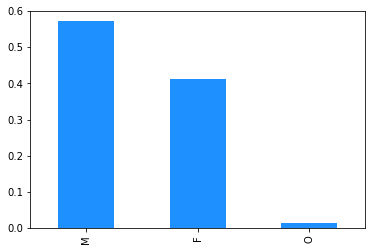

In [13]:
df_p['gender'].value_counts(normalize=True).plot.bar(color='dodgerblue');

In [14]:
df_p['gender'].value_counts(normalize=True)

M   0.57
F   0.41
O   0.01
Name: gender, dtype: float64

The majority of records belongs to Male users (57%)

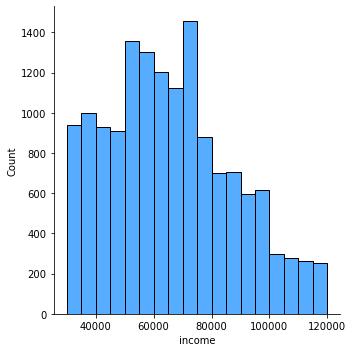

In [15]:
sns.displot(df_p, x="income", color='dodgerblue', binwidth=5000);

In [16]:
df_p['income'].describe()

count    14,825.00
mean     65,404.99
std      21,598.30
min      30,000.00
25%      49,000.00
50%      64,000.00
75%      80,000.00
max     120,000.00
Name: income, dtype: float64

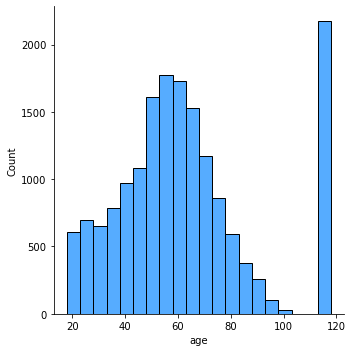

In [17]:
sns.displot(df_p, x="age", color='dodgerblue', binwidth=5);

There are some outliers in the `age` column

In [18]:
df_p['age'].describe(percentiles=[0.8, 0.9, 0.95, 0.98, 0.99])

count   17,000.00
mean        62.53
std         26.74
min         18.00
50%         58.00
80%         78.00
90%        118.00
95%        118.00
98%        118.00
99%        118.00
max        118.00
Name: age, dtype: float64

In [19]:
df_p[(df_p['age'] > 80) & (df_p['age'] <= 100)]

,gender,age,id,became_member_on,income
33,F,96,868317b9be554cb18e50bc68484749a2,20171117,"89,000.00"
94,F,89,4264b1d027cc493281bba4f44bfedaca,20171114,"87,000.00"
98,F,90,1c587de019994f93a242c6864fd7bc55,20151210,"98,000.00"
126,M,83,4c29d22467af4d7faa137c4eedd65340,20180127,"46,000.00"
131,F,89,3dae0eadb47149b0b9b548d14548524b,20180114,"65,000.00"
...,...,...,...,...,...
16914,M,87,d1c4500ace2e45e9a45d3cd2fccac8d8,20140920,"59,000.00"
16933,M,85,a65353ea28ff442aabfb39eb974326e3,20161001,"96,000.00"
16938,F,89,da7bf9d84fd74a72bdee595007bcca7a,20170413,"68,000.00"
16981,M,84,1966fa40d2f84620b2b1b9b64f8e0209,20160629,"93,000.00"


In [20]:
df_p[df_p['age'] > 100]

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,NaN,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,NaN,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,NaN,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,NaN,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,NaN,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,NaN,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [21]:
df_p[df_p['age'] > 100]['income'].isnull().sum()

2175

In [22]:
df_p[df_p['age'] > 100]['gender'].isnull().sum()

2175

It seems that there are 2,175 users who didn't provide gender and income information. Also, these users identified themselves as over 100 y.o., which looks suspicious.

In [23]:
print (df_p.dtypes)

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object


`became_member_on` column has int data type

***How are we going to clean up the data?***

1. Deal with age over 100 y.o.
2. Deal with null values in `income` and `gender` columns
3. Change data type from int to datetime for `became_member_on` column

***What kind of new features we can create?***

1. `days_being_member` column can be created using `became_member_on` column
2. Change values for `gender`column. 
Instead of using F, M and O values, we can use numbers 1 - F, 2 - M, O - 3.

### Portfolio data

In [24]:
df_port = pd.read_csv("./data/starbucks/portfolio.csv")

In [25]:
df_port

,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [26]:
# Drop redundant column
df_port.drop(columns=['Unnamed: 0'], inplace=True)

In [27]:
df_port.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [28]:
df_port['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [29]:
# Rename columns
df_port.columns = ['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'offer_id']

### Transcript data

In [30]:
df_t = pd.read_csv("./data/starbucks/transcript.csv")

In [31]:
df_t.head()

,Unnamed: 0,person,event,value,time
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [32]:
# Drop redundant column
df_t.drop(columns=['Unnamed: 0'], inplace=True)

In [33]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [34]:
df_t['person'].nunique()

17000

17,000 unique users as in the Profile data

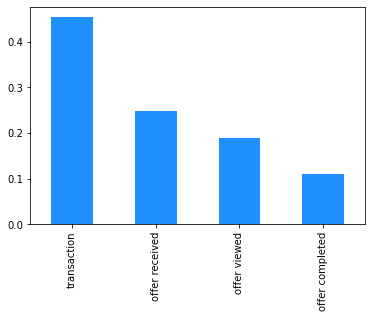

In [35]:
df_t['event'].value_counts(normalize=True).plot.bar(color='dodgerblue');

Let's check transactions only

In [36]:
df_t[df_t['event'] == 'transaction']['value'].unique().tolist()

["{'amount': 0.8300000000000001}",
 "{'amount': 34.56}",
 "{'amount': 13.23}",
 "{'amount': 19.51}",
 "{'amount': 18.97}",
 "{'amount': 33.9}",
 "{'amount': 0.22}",
 "{'amount': 18.59}",
 "{'amount': 18.01}",
 "{'amount': 19.11}",
 "{'amount': 36.19}",
 "{'amount': 6.46}",
 "{'amount': 5.02}",
 "{'amount': 28.39}",
 "{'amount': 28.08}",
 "{'amount': 0.75}",
 "{'amount': 1.02}",
 "{'amount': 13.57}",
 "{'amount': 10.22}",
 "{'amount': 31.42}",
 "{'amount': 27.89}",
 "{'amount': 4.2}",
 "{'amount': 13.05}",
 "{'amount': 1.16}",
 "{'amount': 38.38}",
 "{'amount': 4.08}",
 "{'amount': 5.78}",
 "{'amount': 14.27}",
 "{'amount': 11.52}",
 "{'amount': 13.93}",
 "{'amount': 4.05}",
 "{'amount': 30.03}",
 "{'amount': 21.84}",
 "{'amount': 10.37}",
 "{'amount': 1.21}",
 "{'amount': 5.46}",
 "{'amount': 7.4}",
 "{'amount': 2.95}",
 "{'amount': 19.82}",
 "{'amount': 11.83}",
 "{'amount': 5.31}",
 "{'amount': 2.44}",
 "{'amount': 3.26}",
 "{'amount': 24.8}",
 "{'amount': 1.23}",
 "{'amount': 17.0}"

Let's check offers only

In [37]:
df_t[df_t['event'] != 'transaction']['value'].unique().tolist()

["{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}",
 "{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}",
 "{'offer id': '2906b810c7d4411798c6938adc9daaa5'}",
 "{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}",
 "{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}",
 "{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}",
 "{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}",
 "{'offer id': '3f207df678b143eea3cee63160fa8bed'}",
 "{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}",
 "{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}",
 "{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}",
 "{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}",
 "{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}",
 "{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}",
 "{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10}",
 "{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}",
 "{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}",
 "{'of

We can create features for each user to show thier behavior in making transactions and using the offers.

## Data cleaning

### Profile data

We decided to have the following data cleaning steps:
1. Deal with age over 100 y.o.
2. Deal with null values in `income` and `gender` columns
3. Change data type from int to datetime for `became_member_on` column

#### Deal with age over 100 y.o. & Null values

In [38]:
df_p = df_p[df_p['age'] <= 100]

In [39]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14820 non-null  object 
 1   age               14820 non-null  int64  
 2   id                14820 non-null  object 
 3   became_member_on  14820 non-null  int64  
 4   income            14820 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.7+ KB


In [40]:
df_p.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

If we remove age records for more than 100 y.o., there are no null records

In [41]:
df_p.describe()

,age,became_member_on,income
count,"14,820.00","14,820.00","14,820.00"
mean,54.38,"20,166,887.17","65,404.18"
std,17.37,"11,886.72","21,598.76"
min,18.00,"20,130,729.00","30,000.00"
25%,42.00,"20,160,520.00","49,000.00"
50%,55.00,"20,170,802.00","64,000.00"
75%,66.00,"20,171,230.00","80,000.00"
max,100.00,"20,180,726.00","120,000.00"


#### Change data type from int to datetime for `became_member_on` column

In [42]:
df_p['became_member_on'] = pd.to_datetime(df_p['became_member_on'], format='%Y%m%d')

In [43]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14820 non-null  object        
 1   age               14820 non-null  int64         
 2   id                14820 non-null  object        
 3   became_member_on  14820 non-null  datetime64[ns]
 4   income            14820 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 694.7+ KB


In [44]:
df_p.sample(5)

,gender,age,id,became_member_on,income
1143,M,42,d4a1f79859224f558228bda4029c4816,2018-05-19,"33,000.00"
16025,F,59,6fc5509d00634baf8afe57c185a81ab2,2015-12-25,"50,000.00"
8278,F,20,3497bd1dd534441bb31d5f8949fde980,2017-07-31,"48,000.00"
3563,F,53,b5105f071088481c8382eb9f73cd6a27,2017-12-11,"48,000.00"
13822,M,69,978e868c211a4e249c1c449b43c7a079,2018-06-04,"62,000.00"


## Feature engineering

### Profile data

**Ideas on feature engineering:**
1. `days_being_member` column can be created using `became_member_on` column
2. Change values for `gender`column. 
Instead of using F, M and O values, we can use numbers 1 - F, 2 - M, O - 3.

#### Create column `days_being_member` 

In [45]:
df_p['became_member_on'].min(), df_p['became_member_on'].max()

(Timestamp('2013-07-29 00:00:00'), Timestamp('2018-07-26 00:00:00'))

In [46]:
# Create a feature
# Let's calculate from the latest date available in the dataframe
df_p['days_being_member'] = (df_p['became_member_on'].max() - df_p['became_member_on']).dt.days

In [47]:
df_p['days_being_member'].describe(percentiles=[0.8])

count   14,820.00
mean       522.49
std        419.23
min          0.00
50%        358.00
80%        885.00
max      1,823.00
Name: days_being_member, dtype: float64

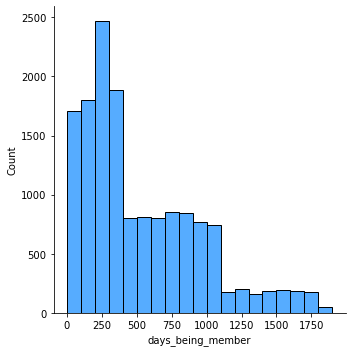

In [48]:
sns.displot(df_p, x="days_being_member", color='dodgerblue', binwidth=100);

The majority of users had an app for at least 885 days, which is less than 2.5 years.

#### Change values for `gender` column

In [49]:
df_p['gender'].value_counts()

M    8484
F    6124
O     212
Name: gender, dtype: int64

In [50]:
map_dict = {"F": 1,
            "M": 2,
            "O": 3}

In [51]:
df_p['gender'] = df_p['gender'].map(map_dict)

In [52]:
df_p['gender'].value_counts()

2    8484
1    6124
3     212
Name: gender, dtype: int64

Let's look at the cleaned and transfromed data

In [53]:
df_p.head()

,gender,age,id,became_member_on,income,days_being_member
1,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,"112,000.00",376
3,1,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,"100,000.00",443
5,2,68,e2127556f4f64592b11af22de27a7932,2018-04-26,"70,000.00",91
8,2,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,"53,000.00",167
12,2,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,"51,000.00",257


In [54]:
df_p['id'].nunique()

14820

We removed records for about 13% of unique users

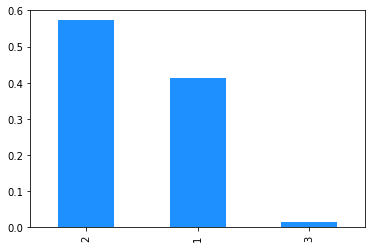

In [55]:
df_p['gender'].value_counts(normalize=True).plot.bar(color='dodgerblue');

Male users are dominant

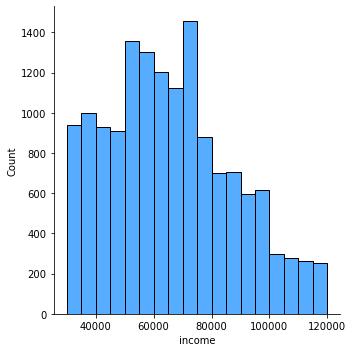

In [56]:
sns.displot(df_p, x="income", color='dodgerblue', binwidth=5000);

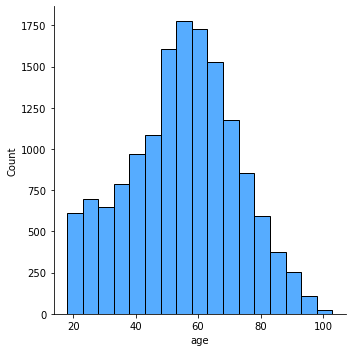

In [57]:
sns.displot(df_p, x="age", color='dodgerblue', binwidth=5);

In [58]:
# Let's change column name for 'id' to 'person' 
df_p.columns = ['gender', 'age', 'person', 'became_member_on', 'income', 'days_being_member']

In [59]:
df_p.head(2)

,gender,age,person,became_member_on,income,days_being_member
1,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,"112,000.00",376
3,1,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,"100,000.00",443


In [60]:
# Let's drop column 'became_member_on'
df_p.drop(columns=['became_member_on'], inplace=True)

In [61]:
# Let's save cleaned data
df_p.to_csv("./data/starbucks/profile_clean.csv", index=False)

### Transcript data

In [62]:
df_t.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


Let's separate data into offers and transactions

In [63]:
df_tr = df_t[df_t['event'] == 'transaction']
df_off = df_t[df_t['event'] != 'transaction']

#### Engineering transaction features

In [64]:
df_tr.head(2)

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0


In [65]:
print("Percentage of transaction data out of all records: ", (df_tr.shape[0] / df_t.shape[0]) * 100)

Percentage of transaction data out of all records:  45.33037118231583


In [66]:
df_tr['person'].nunique()

16578

In [67]:
# Create transaction amount column
df_tr['transactions_amount'] = df_tr['value'].str[11:16]
df_tr['transactions_amount'] = df_tr['transactions_amount'].str.replace('}', '')
df_tr['transactions_amount'] = df_tr['transactions_amount'].astype(float)

In [68]:
df_tr.head()

,person,event,value,time,transactions_amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,18.97


In [69]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138953 entries, 12654 to 306533
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   person               138953 non-null  object 
 1   event                138953 non-null  object 
 2   value                138953 non-null  object 
 3   time                 138953 non-null  int64  
 4   transactions_amount  138953 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 6.4+ MB


In [70]:
# Create a column with transactions
df_tr['transactions'] = 1

In [71]:
df_tr.head()

,person,event,value,time,transactions_amount,transactions
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83,1
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56,1
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23,1
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,19.51,1
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,18.97,1


Let's aggregate the transaction data per user using sum aggregation

In [72]:
df_tr_agg = df_tr.groupby('person').agg({'transactions_amount':'sum',
                                         'transactions':'sum'}).reset_index()

In [73]:
df_tr_agg.head()

,person,transactions_amount,transactions
0,0009655768c64bdeb2e877511632db8f,127.60,8
1,00116118485d4dfda04fdbaba9a87b5c,4.09,3
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,5
3,0020c2b971eb4e9188eac86d93036a77,196.86,8
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12


In [74]:
df_tr_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16578 entries, 0 to 16577
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   person               16578 non-null  object 
 1   transactions_amount  16578 non-null  float64
 2   transactions         16578 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 388.7+ KB


In [75]:
df_tr_agg.describe(percentiles=[0.8])

,transactions_amount,transactions
count,"16,578.00","16,578.00"
mean,107.10,8.38
std,126.39,5.01
min,0.05,1.00
50%,72.41,7.00
80%,170.65,12.00
max,"1,608.60",36.00


#### Engineering offers related features

In [76]:
df_off.head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [77]:
df_off['person'].nunique()

16994

In [78]:
# Create a column with offer ids
df_off['offer_id'] = df_off['value'].str[14:46]

In [79]:
df_off.head(3)

,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5


In [80]:
# Let's add offer type
df_off = pd.merge(df_off, df_port[['offer_type', 'offer_id']],
                  left_on=['offer_id'],
                  right_on=['offer_id'],
                  how='left')

In [81]:
df_off.head(3)

,person,event,value,time,offer_id,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,discount


***Apply one-hot encoding***

In [82]:
df_off_one_hot_enc = pd.get_dummies(df_off, columns = ['event', 'offer_type'])

In [83]:
df_off_one_hot_enc.head(2)

,person,value,time,offer_id,event_offer completed,event_offer received,event_offer viewed,offer_type_bogo,offer_type_discount,offer_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,1,0


In [84]:
df_off_one_hot_enc.columns = ['person', 'value', 'time', 'offer_id', 'offers_completed',
                              'offers_received', 'offers_viewed', 'offer_type_bogo_cnt',
                              'offer_type_discount_cnt', 'offer_type_informational_cnt']

In [85]:
df_off_agg = df_off_one_hot_enc.groupby('person').agg({'offers_completed':'sum',
                                                       'offers_received':'sum',
                                                       'offers_viewed':'sum',
                                                       'offer_type_bogo_cnt':'sum',
                                                       'offer_type_discount_cnt':'sum',
                                                       'offer_type_informational_cnt':'sum'}).reset_index()

In [86]:
df_off_agg.head()

,person,offers_completed,offers_received,offers_viewed,offer_type_bogo_cnt,offer_type_discount_cnt,offer_type_informational_cnt
0,0009655768c64bdeb2e877511632db8f,3,5,4,3,5,4
1,00116118485d4dfda04fdbaba9a87b5c,0,2,2,4,0,0
2,0011e0d4e6b944f998e987f904e8c1e5,3,5,5,3,6,4
3,0020c2b971eb4e9188eac86d93036a77,3,5,3,4,5,2
4,0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,6,3,2


In [87]:
df_off_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16994 entries, 0 to 16993
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   person                        16994 non-null  object
 1   offers_completed              16994 non-null  uint8 
 2   offers_received               16994 non-null  uint8 
 3   offers_viewed                 16994 non-null  uint8 
 4   offer_type_bogo_cnt           16994 non-null  uint8 
 5   offer_type_discount_cnt       16994 non-null  uint8 
 6   offer_type_informational_cnt  16994 non-null  uint8 
dtypes: object(1), uint8(6)
memory usage: 232.5+ KB


#### Merge transactions and offfer data

In [88]:
df_off_agg['person'].nunique()

16994

In [89]:
df_tr_agg['person'].nunique()

16578

In [90]:
df_tr_off = pd.merge(df_tr_agg, df_off_agg,
                     left_on=['person'], right_on=['person'],
                     how='outer')

In [91]:
df_tr_off.head()

,person,transactions_amount,transactions,offers_completed,offers_received,offers_viewed,offer_type_bogo_cnt,offer_type_discount_cnt,offer_type_informational_cnt
0,0009655768c64bdeb2e877511632db8f,127.60,8.00,3.00,5.00,4.00,3.00,5.00,4.00
1,00116118485d4dfda04fdbaba9a87b5c,4.09,3.00,0.00,2.00,2.00,4.00,0.00,0.00
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,5.00,3.00,5.00,5.00,3.00,6.00,4.00
3,0020c2b971eb4e9188eac86d93036a77,196.86,8.00,3.00,5.00,3.00,4.00,5.00,2.00
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12.00,3.00,4.00,4.00,6.00,3.00,2.00


In [92]:
df_tr_off['person'].nunique()

17000

In [93]:
df_tr_off.isnull().sum()

person                            0
transactions_amount             422
transactions                    422
offers_completed                  6
offers_received                   6
offers_viewed                     6
offer_type_bogo_cnt               6
offer_type_discount_cnt           6
offer_type_informational_cnt      6
dtype: int64

In [94]:
df_tr_off.fillna(-1, inplace=True)

In [95]:
df_tr_off.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   person                        17000 non-null  object 
 1   transactions_amount           17000 non-null  float64
 2   transactions                  17000 non-null  float64
 3   offers_completed              17000 non-null  float64
 4   offers_received               17000 non-null  float64
 5   offers_viewed                 17000 non-null  float64
 6   offer_type_bogo_cnt           17000 non-null  float64
 7   offer_type_discount_cnt       17000 non-null  float64
 8   offer_type_informational_cnt  17000 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


### Merge profile and transcript data

In [96]:
df_p.head()

,gender,age,person,income,days_being_member
1,1,55,0610b486422d4921ae7d2bf64640c50b,"112,000.00",376
3,1,75,78afa995795e4d85b5d9ceeca43f5fef,"100,000.00",443
5,2,68,e2127556f4f64592b11af22de27a7932,"70,000.00",91
8,2,65,389bc3fa690240e798340f5a15918d5c,"53,000.00",167
12,2,58,2eeac8d8feae4a8cad5a6af0499a211d,"51,000.00",257


In [97]:
df_p['person'].nunique()

14820

In [98]:
df_p.shape

(14820, 5)

In [99]:
df = pd.merge(df_p, df_tr_off, left_on='person', right_on='person', how='left')

In [100]:
df.head()

,gender,age,person,income,days_being_member,transactions_amount,transactions,offers_completed,offers_received,offers_viewed,offer_type_bogo_cnt,offer_type_discount_cnt,offer_type_informational_cnt
0,1,55,0610b486422d4921ae7d2bf64640c50b,"112,000.00",376,77.01,3.00,1.00,2.00,0.00,2.00,0.00,1.00
1,1,75,78afa995795e4d85b5d9ceeca43f5fef,"100,000.00",443,159.27,7.00,3.00,4.00,4.00,9.00,0.00,2.00
2,2,68,e2127556f4f64592b11af22de27a7932,"70,000.00",91,57.73,3.00,2.00,4.00,3.00,3.00,5.00,1.00
3,2,65,389bc3fa690240e798340f5a15918d5c,"53,000.00",167,36.43,3.00,5.00,6.00,6.00,11.00,6.00,0.00
4,2,58,2eeac8d8feae4a8cad5a6af0499a211d,"51,000.00",257,15.62,4.00,1.00,3.00,2.00,0.00,5.00,1.00


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 0 to 14819
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        14820 non-null  int64  
 1   age                           14820 non-null  int64  
 2   person                        14820 non-null  object 
 3   income                        14820 non-null  float64
 4   days_being_member             14820 non-null  int64  
 5   transactions_amount           14820 non-null  float64
 6   transactions                  14820 non-null  float64
 7   offers_completed              14820 non-null  float64
 8   offers_received               14820 non-null  float64
 9   offers_viewed                 14820 non-null  float64
 10  offer_type_bogo_cnt           14820 non-null  float64
 11  offer_type_discount_cnt       14820 non-null  float64
 12  offer_type_informational_cnt  14820 non-null  float64
dtypes

In [102]:
# Let's save the dataset we will work with in the next sections
df.to_csv("./data/starbucks/combined.csv", index=False)

## Analysis

In [103]:
df = pd.read_csv("./data/starbucks/combined.csv")

In [104]:
df.head()

,gender,age,person,income,days_being_member,transactions_amount,transactions,offers_completed,offers_received,offers_viewed,offer_type_bogo_cnt,offer_type_discount_cnt,offer_type_informational_cnt
0,1,55,0610b486422d4921ae7d2bf64640c50b,"112,000.00",376,77.01,3.00,1.00,2.00,0.00,2.00,0.00,1.00
1,1,75,78afa995795e4d85b5d9ceeca43f5fef,"100,000.00",443,159.27,7.00,3.00,4.00,4.00,9.00,0.00,2.00
2,2,68,e2127556f4f64592b11af22de27a7932,"70,000.00",91,57.73,3.00,2.00,4.00,3.00,3.00,5.00,1.00
3,2,65,389bc3fa690240e798340f5a15918d5c,"53,000.00",167,36.43,3.00,5.00,6.00,6.00,11.00,6.00,0.00
4,2,58,2eeac8d8feae4a8cad5a6af0499a211d,"51,000.00",257,15.62,4.00,1.00,3.00,2.00,0.00,5.00,1.00


### Customer segmentation

*Customer segmentation* is the process of dividing customers into groups based on common characteristics, which allows companies market each group effectively and appropriately. Segmentation helps marketers to better tailor their marketing efforts to various audience subsets, which can relate to both communications and product development.

In [105]:
# Let's spleet the dataframe into features and labels
df_X = df.drop(columns=['person'])
df_y = df[['person']]

#### Normalize data

Clustering algorithms are highly affected by the scales of the data, so we need to normalize this data to be on the same scale.

In [106]:
# Normalize the data
scaler = MinMaxScaler()
X_sc = scaler.fit_transform(df_X)

In [107]:
# Create dataframe with scaled data
df_X_sc = pd.DataFrame(X_sc, columns = df_X.columns)

In [108]:
df_X_sc

,gender,age,income,days_being_member,transactions_amount,transactions,offers_completed,offers_received,offers_viewed,offer_type_bogo_cnt,offer_type_discount_cnt,offer_type_informational_cnt
0,0.00,0.45,0.91,0.21,0.05,0.11,0.29,0.43,0.14,0.16,0.06,0.18
1,0.00,0.70,0.78,0.24,0.10,0.22,0.57,0.71,0.71,0.53,0.06,0.27
2,0.50,0.61,0.44,0.05,0.04,0.11,0.43,0.71,0.57,0.21,0.33,0.18
3,0.50,0.57,0.26,0.09,0.02,0.11,0.86,1.00,1.00,0.63,0.39,0.09
4,0.50,0.49,0.23,0.14,0.01,0.14,0.29,0.57,0.43,0.05,0.33,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...
14815,0.00,0.33,0.27,0.03,0.01,0.22,0.14,0.57,0.57,0.16,0.17,0.27
14816,0.50,0.52,0.47,0.01,0.02,0.22,0.29,0.57,0.29,0.16,0.06,0.36
14817,0.50,0.38,0.48,0.30,0.03,0.24,0.14,0.57,0.29,0.05,0.11,0.36
14818,0.00,0.79,0.22,0.48,0.12,0.41,0.57,0.57,0.57,0.53,0.06,0.09


In [109]:
df_X_sc.describe()

,gender,age,income,days_being_member,transactions_amount,transactions,offers_completed,offers_received,offers_viewed,offer_type_bogo_cnt,offer_type_discount_cnt,offer_type_informational_cnt
count,"14,820.00","14,820.00","14,820.00","14,820.00","14,820.00","14,820.00","14,820.00","14,820.00","14,820.00","14,820.00","14,820.00","14,820.00"
mean,0.30,0.44,0.39,0.29,0.07,0.25,0.46,0.78,0.62,0.28,0.29,0.23
std,0.26,0.21,0.24,0.23,0.08,0.14,0.23,0.15,0.18,0.15,0.16,0.14
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.29,0.21,0.11,0.02,0.14,0.29,0.71,0.43,0.16,0.17,0.09
50%,0.50,0.45,0.38,0.20,0.05,0.22,0.43,0.86,0.57,0.26,0.28,0.27
75%,0.50,0.59,0.56,0.44,0.10,0.32,0.57,0.86,0.71,0.37,0.39,0.27
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


#### Define the number of clusters

##### Silhouette coefficient

**Formula for the Silhouette coefficient**: *S = (b - a)/max(a, b)*

where *b* is the average of the distance between a point and its closest cluster, *a* is the average distance among data points within the same cluster. Sillhouette coefficient ranges from -1 to 1, where the closer the values are to 1, the better they are.

In [110]:
for n_cluster in [2, 3, 4, 5, 6, 7, 8]:
    kmeans = KMeans(n_clusters=n_cluster, max_iter=400, n_init=20).fit(df_X_sc)
    silhouette_avg = silhouette_score(df_X_sc,
                                      kmeans.labels_) 
    print('Silhouette coefficient for %i clusters: %0.3f' % (n_cluster, silhouette_avg))

Silhouette coefficient for 2 clusters: 0.158
Silhouette coefficient for 3 clusters: 0.158
Silhouette coefficient for 4 clusters: 0.153
Silhouette coefficient for 5 clusters: 0.155
Silhouette coefficient for 6 clusters: 0.151
Silhouette coefficient for 7 clusters: 0.148
Silhouette coefficient for 8 clusters: 0.129


Looking at the Silhouette coefficients, I will choose number of clusters=2.

### Build k-means clustering model

In [111]:
kmeans = KMeans(n_clusters=2,
                max_iter=400, n_init=20).fit(df_X_sc)

In [112]:
kmeans.labels_

array([1, 0, 1, ..., 1, 0, 0], dtype=int32)

In [113]:
df['cluster'] =  kmeans.labels_

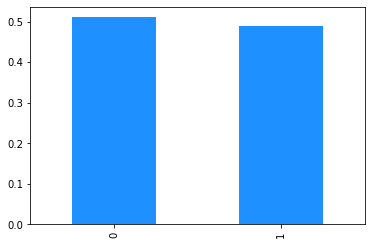

In [114]:
df['cluster'].value_counts(normalize=True).plot.bar(color='dodgerblue');

The users are separated into clusters almost evenly

### What is the difference between the segments/user personas?

In [115]:
df_copy = df.copy()

In [116]:
df.drop(columns=['person'], inplace=True)

In [117]:
df

,gender,age,income,days_being_member,transactions_amount,transactions,offers_completed,offers_received,offers_viewed,offer_type_bogo_cnt,offer_type_discount_cnt,offer_type_informational_cnt,cluster
0,1,55,"112,000.00",376,77.01,3.00,1.00,2.00,0.00,2.00,0.00,1.00,1
1,1,75,"100,000.00",443,159.27,7.00,3.00,4.00,4.00,9.00,0.00,2.00,0
2,2,68,"70,000.00",91,57.73,3.00,2.00,4.00,3.00,3.00,5.00,1.00,1
3,2,65,"53,000.00",167,36.43,3.00,5.00,6.00,6.00,11.00,6.00,0.00,0
4,2,58,"51,000.00",257,15.62,4.00,1.00,3.00,2.00,0.00,5.00,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14815,1,45,"54,000.00",52,20.03,7.00,0.00,3.00,3.00,2.00,2.00,2.00,1
14816,2,61,"72,000.00",13,25.97,7.00,1.00,3.00,1.00,2.00,0.00,3.00,1
14817,2,49,"73,000.00",546,39.74,8.00,0.00,3.00,1.00,0.00,1.00,3.00,1
14818,1,83,"50,000.00",871,189.67,14.00,3.00,3.00,3.00,9.00,0.00,0.00,0


#### Random forest classifier

In [118]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'cluster'],\
                                                    df['cluster'], stratify=df['cluster'],\
                                                    test_size = 0.2, random_state=23)

In [119]:
X_train.shape

(11856, 12)

In [120]:
X_test.shape

(2964, 12)

In [121]:
rf = RandomForestClassifier(n_estimators=500,
                            max_depth=8,
                            random_state=23,
                            max_features='sqrt',
                            n_jobs=-1,
                            class_weight='balanced')
rf.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = rf.predict(X_test)

# Print accuracy for the training and test sets
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

Accuracy on training set: 0.973
Accuracy on test set: 0.951


In [122]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)

array([[1450,   64],
       [  80, 1370]])

In [123]:
# Precision
precision_score(y_test, y_pred_test, average=None)[0]

0.9477124183006536

In [124]:
# Recall
recall_score(y_test, y_pred_test, average=None)[0]

0.9577278731836195

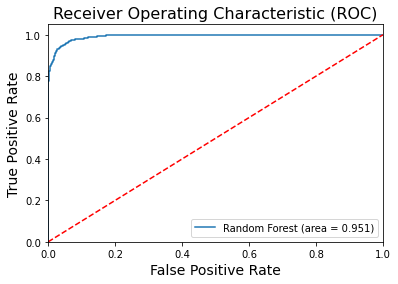

In [125]:
# Building ROC curve
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.3f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show();

#### SHAP values

In [ ]:
%%time
samples = X_test

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

shap.summary_plot(shap_values[1], samples)

In [ ]:
def make_feature_importance_plot(shap_values, features, num_display=20):
    
    '''
    A function for building a SHAP feature importance plot.
    
    SHAP feature importance is used to visualize the most important features in a descending order.
    
    Parameters:
    shap_values (list): SHAP values obtained from a model
    features (pandas DataFrame): a list of features used in a model
    num_display(int): number of features to display
    
    Returns:
    matplotlib.pyplot plot: SHAP waterfall plot
    
    '''
    
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))

In [ ]:
# Shapp waterfall plot
make_feature_importance_plot(shap_values[1], samples)

In [ ]:
# Let's have a look on the top features and their dependence plots
top_features = ['offers_completed', 'gender', 'transactions_amount',
                'income', 'offers_viewed', 'days_being_member']

In [ ]:
for feature in top_features:
    shap.dependence_plot(feature, shap_values[1], samples, interaction_index=None)